<a href="https://colab.research.google.com/github/prachieeee/Stock-Price-Prediction/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Load and preprocess data from train_dataset.csv and test_dataset.csv
train_data = pd.read_csv("/content/train_dataset.csv")
test_data = pd.read_csv("/content/test_dataset.csv")

# Keep only the 'Date' and 'Close' columns
train_data = train_data[['Date', 'Close']]
test_data = test_data[['Date', 'Close']]

In [3]:
# Function to convert string dates to datetime objects
def str_to_datetime(date_str):
    day, month, year = map(int, date_str.split('-'))
    return datetime.datetime(year=year, month=month, day=day)

# Apply the date conversion to both datasets
train_data['Date'] = train_data['Date'].apply(str_to_datetime)
train_data.index = train_data.pop('Date')

test_data['Date'] = test_data['Date'].apply(str_to_datetime)
test_data.index = test_data.pop('Date')

In [4]:
# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()
train_data['Close'] = scaler.fit_transform(train_data[['Close']])
test_data['Close'] = scaler.transform(test_data[['Close']])

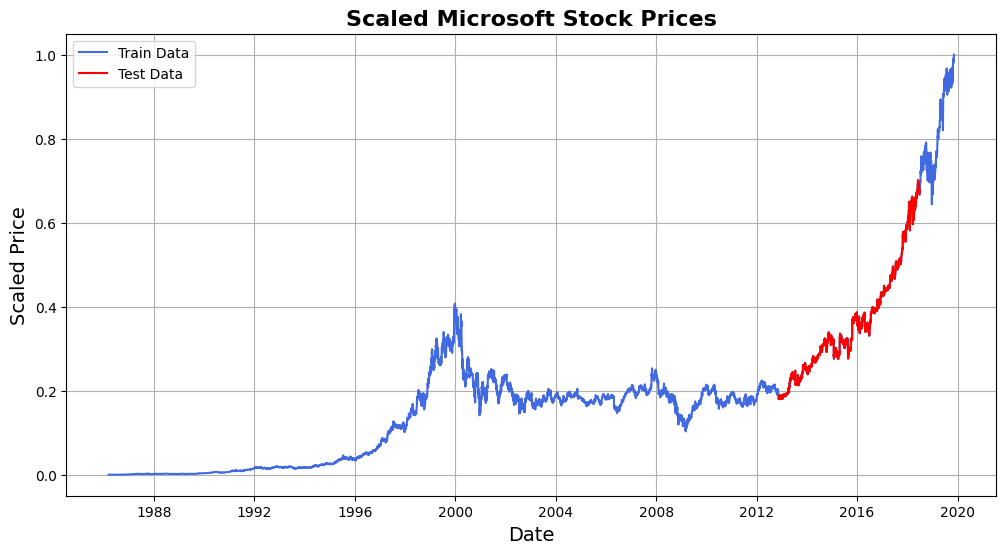

In [5]:
# Plot the stock data
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Close'], color='royalblue', label='Train Data')
plt.plot(test_data.index, test_data['Close'], color='red', label='Test Data')
plt.title("Scaled Microsoft Stock Prices", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Scaled Price", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [6]:
# Create windowed data function
def create_windowed_data(dataframe, window_size=5):
    dates, X, Y = [], [], []
    for i in range(window_size, len(dataframe)):
        x = dataframe['Close'].iloc[i-window_size:i].to_numpy()
        y = dataframe['Close'].iloc[i]
        dates.append(dataframe.index[i])
        X.append(x)
        Y.append(y)
    return pd.DataFrame({'Target Date': dates, 'X': X, 'Y': Y})

In [7]:
# Create windowed data for training and testing
window_size = 5
train_windowed_data = create_windowed_data(train_data, window_size=window_size)
test_windowed_data = create_windowed_data(test_data, window_size=window_size)

In [8]:
# Prepare the data for LSTM model (reshaping)
def prepare_X_y(windowed_dataframe):
    X = np.array(windowed_dataframe['X'].tolist())
    Y = np.array(windowed_dataframe['Y'].tolist())
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshaping for LSTM input
    return windowed_dataframe['Target Date'], X.astype(np.float32), Y.astype(np.float32)

In [9]:
# Prepare train and test sets
dates_train, X_train, y_train = prepare_X_y(train_windowed_data)
dates_test, X_test, y_test = prepare_X_y(test_windowed_data)

In [10]:
# Split train data into train and validation sets (80-20 split)
val_split = int(len(dates_train) * 0.8)
dates_val, X_val, y_val = dates_train[val_split:], X_train[val_split:], y_train[val_split:]
dates_train, X_train, y_train = dates_train[:val_split], X_train[:val_split], y_train[:val_split]

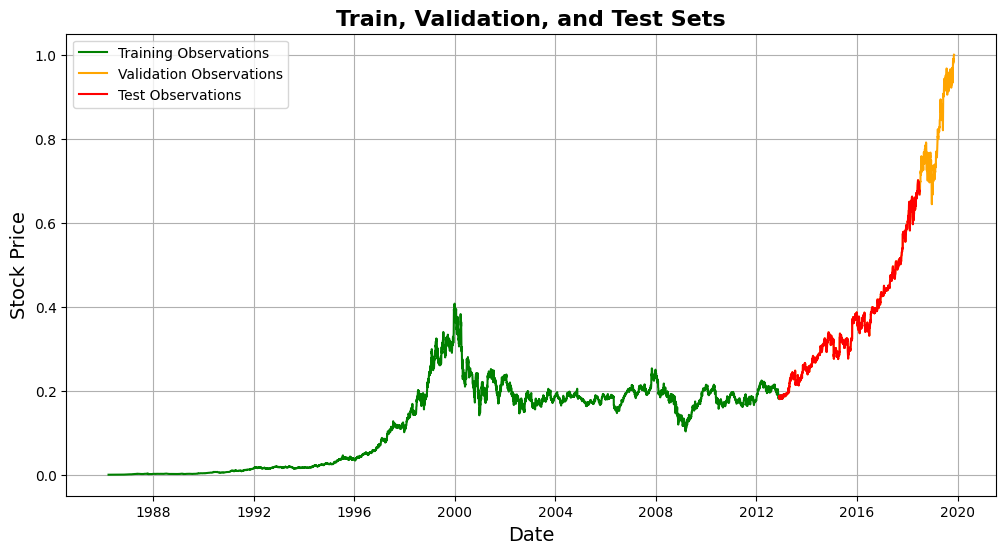

In [11]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train, color='green', label='Training Observations')
plt.plot(dates_val, y_val, color='orange', label='Validation Observations')
plt.plot(dates_test, y_test, color='red', label='Test Observations')
plt.title("Train, Validation, and Test Sets", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Stock Price", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [12]:
# Build LSTM model with extra units and batch normalization
model = Sequential([
    layers.Input((window_size, 1)),
    layers.LSTM(256, return_sequences=True),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1)
])

In [13]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

In [15]:
# Train the model and store history for accuracy/loss plotting
model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 4.5454e-04 - mean_absolute_error: 0.0164 - val_loss: 0.1127 - val_mean_absolute_error: 0.2971 - learning_rate: 1.0000e-04
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 4.1064e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0394 - val_mean_absolute_error: 0.1742 - learning_rate: 1.0000e-04
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 2.5956e-04 - mean_absolute_error: 0.0121 - val_loss: 0.0033 - val_mean_absolute_error: 0.0411 - learning_rate: 1.0000e-04
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - loss: 2.1098e-04 - mean_absolute_error: 0.0109 - val_loss: 0.0015 - val_mean_absolute_error: 0.0220 - learning_rate: 1.0000e-04
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 1.7604e-04 - mean_absolute_error: 0.0100 - val_loss: 0.0018 - val_mean_absolute_error: 0.0378 - learning_rate: 1.0000e-04
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 1.8159e-04 - mean_a

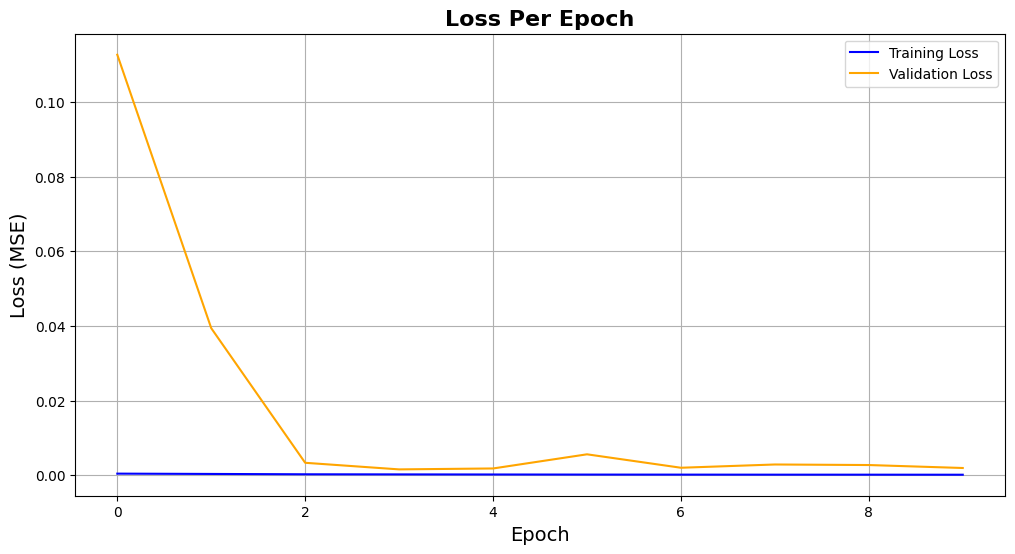

In [16]:
# Plot accuracy and loss per epoch
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Loss Per Epoch", fontsize=16, fontweight='bold')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss (MSE)", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [17]:
# Predictions and evaluations
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [18]:
# Reverse scaling
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, 1)).flatten()
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

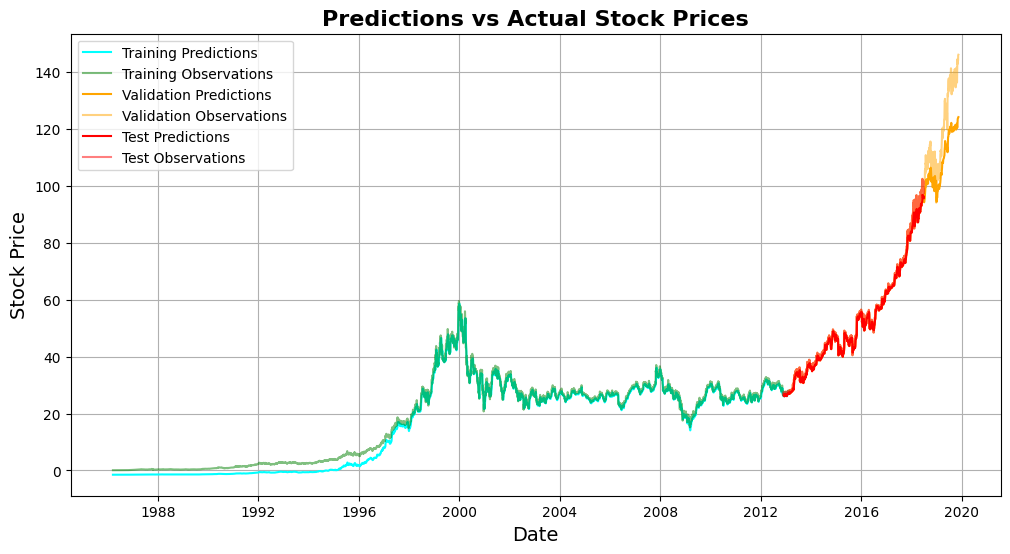

In [19]:
# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(dates_train, train_predictions, color='cyan', label='Training Predictions')
plt.plot(dates_train, y_train, color='green', alpha=0.5, label='Training Observations')
plt.plot(dates_val, val_predictions, color='orange', label='Validation Predictions')
plt.plot(dates_val, y_val, color='orange', alpha=0.5, label='Validation Observations')
plt.plot(dates_test, test_predictions, color='red', label='Test Predictions')
plt.plot(dates_test, y_test, color='red', alpha=0.5, label='Test Observations')
plt.title("Predictions vs Actual Stock Prices", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Stock Price", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [20]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE:", rmse)

RMSE: 1.6841468


In [21]:
# Calculate accuracy in percentage using MAPE
mape = mean_absolute_percentage_error(y_test, test_predictions)
accuracy = 100 - mape * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 97.81%
